<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/EMW_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import numpy as np
from scipy import integrate
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=cuda,floatX=float32"
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') 
dataDict = pickle.load(f,encoding='bytes')
print(type(dataDict))   # dict
print(len(dataDict))  #220=11（类别）×20（20个snr）

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
<class 'dict'>
220


In [3]:
data = []
labels = []
for d in dataDict:
   signals=dataDict[d]
   for s in signals:
     data.append(np.array(s))
     labels.append(d)
data = np.array(data)
labels = np.array(labels)
print(data.shape) 
print(labels.shape)
print(labels)


(162060, 2, 128)
(162060, 2)
[[b'QPSK' b'2']
 [b'QPSK' b'2']
 [b'QPSK' b'2']
 ...
 [b'WBFM' b'12']
 [b'WBFM' b'12']
 [b'WBFM' b'12']]


In [4]:
# 划分数据集 手动（固定的）和自动（可随机选）

# 使用函数分测试集和训练集
# from sklearn.model_selection import train_test_split
# xTrain, xTest, yTrain, yTest = train_test_split(data,labels, test_size=0.5, random_state=62)

# 手动划分
indices = random.sample(range(0,162060),162060)
xTrain = []
yTrain = []
iTrain = []
for i in range(0,81030):
  xTrain.append(data[indices[i]])
  yTrain.append(labels[indices[i]])
  iTrain.append(indices[i])
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
iTrain = np.array(iTrain)

xTest = []
yTest = []
iTest = []
for i in range(81030, 162060):
  xTest.append(data[indices[i]])
  yTest.append(labels[indices[i]])
  iTest.append(indices[i])
xTest = np.array(xTrain)
yTest = np.array(yTrain)
iTest = np.array(iTest)  

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
print(iTrain.shape)
print(iTest.shape)

(81030, 2, 128)
(81030, 2)
(81030, 2, 128)
(81030, 2)
(81030,)
(81030,)


In [5]:
# one-hot enconding
#Sklearn’s one hot encoder doesn’t actually know how to convert categories to numbers, 
#it only knows how to convert numbers to binary. We have to use the labelencoder first.
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()

yTrain_SNR = yTrain[:,1]
yTest_SNR = yTest[:,1]
print(yTrain_SNR.shape)
print(yTest_SNR.shape)
print(yTrain_SNR)
print(yTest_SNR)
print(yTest[81028])  #随便找一个例子看一下输出结果是否正确
print(yTest_SNR[81028])

yTrain_le = le.fit_transform(yTrain[:, 0])
yTest_le = le.fit_transform(yTest[:, 0])
print(yTrain_le.shape)
print(yTest_le.shape)
print(yTrain_le[81028])
print(yTest_le[81028])   #label编码后

yTrain_le = yTrain_le.reshape(len(yTrain_le), 1)
yTest_le = yTest_le.reshape(len(yTest_le), 1)

enc = OneHotEncoder(categories = 'auto',sparse = False )  #将分类特征的每个元素转化为一个可以用来计算的值
yTrain_ohe = enc.fit_transform(yTrain_le)  # 如果不加 toarray() 的话，输出的是稀疏的存储格式，即索引加值的形式，也可以通过参数指定 sparse = False 来达到同样的效果
yTest_ohe = enc.fit_transform(yTest_le)
print(yTrain_ohe[81028])  #onehot编码后
print(yTest_ohe[81028])  #onehot编码后

(81030,)
(81030,)
[b'-8' b'6' b'-6' ... b'-14' b'4' b'16']
[b'-8' b'6' b'-6' ... b'-14' b'4' b'16']
[b'GFSK' b'4']
b'4'
(81030,)
(81030,)
5
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [30]:
"""##Neural Networks
###CNN
"""
from keras.models import Sequential
from keras.layers import Conv1D, Convolution2D, Flatten, Dense, Reshape
from keras import optimizers

model = Sequential()
in_shp = [2, 128]
model.add(Reshape([1]+in_shp, input_shape=in_shp))
# model.add(Conv2D(filters=64, kernel_size=(1,3), data_format='channels_first', activation='relu', padding='valid'))
# model.add(Conv2D(filters=16, kernel_size=(2,3), data_format='channels_first', activation='relu', padding='valid'))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(64,1,3,border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
# model.add(ZeroPadding2D(0,2))
model.add(Convolution2D(16,1,3,border_mode='valid', activation="relu", name="conv2", init='glorot_uniform'))  # 改了（16，2，3）
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 4, 64)          24640     
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 16)          3088      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 11)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), activation="relu", name="conv1", padding="valid", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 3), activation="relu", name="conv2", padding="valid", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()


In [31]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs=50
batch_size=1000
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=30)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
model.fit(xTrain, yTrain_ohe, validation_split=0.2, shuffle=True, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[es, mc])

Train on 64824 samples, validate on 16206 samples
Epoch 1/50
64824/64824 [==============================] - 2s 27us/step - loss: 2.8050 - accuracy: 0.1753 - val_loss: 2.2453 - val_accuracy: 0.2021
Epoch 2/50
10000/64824 [===>..........................] - ETA: 1s - loss: 2.2109 - accuracy: 0.2118

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


64824/64824 [==============================] - 1s 22us/step - loss: 2.1656 - accuracy: 0.2300 - val_loss: 2.1365 - val_accuracy: 0.2371
Epoch 3/50
64824/64824 [==============================] - 1s 22us/step - loss: 2.0770 - accuracy: 0.2584 - val_loss: 2.0760 - val_accuracy: 0.2514
Epoch 4/50
64824/64824 [==============================] - 1s 21us/step - loss: 2.0198 - accuracy: 0.2732 - val_loss: 2.0427 - val_accuracy: 0.2656
Epoch 5/50
64824/64824 [==============================] - 1s 21us/step - loss: 1.9749 - accuracy: 0.2884 - val_loss: 2.0084 - val_accuracy: 0.2851
Epoch 6/50
64824/64824 [==============================] - 1s 22us/step - loss: 1.9291 - accuracy: 0.3019 - val_loss: 1.9800 - val_accuracy: 0.2994
Epoch 7/50
64824/64824 [==============================] - 1s 22us/step - loss: 1.8726 - accuracy: 0.3183 - val_loss: 1.9240 - val_accuracy: 0.3060
Epoch 8/50
64824/64824 [==============================] - 1s 22us/step - loss: 1.8092 - accuracy: 0.3366 - val_loss: 1.8589 - val

In [33]:
batch_size=1000
score = model.evaluate(xTest, yTest_ohe, verbose=0, batch_size=batch_size)
print (score)   #结果是 1.9665707177208425，不是100%下的结果，这个结果应该是默认的loss
print (score[1])  #报错 'float' object is not subscriptable
print ('loss： %.4lf' % score[0])
print('accuracy: ', score[1])

[0.9570456359263748, 0.7010366320610046]
0.7010366320610046
loss： 0.9570
accuracy:  0.7010366320610046


Accuracy for SNR =  -20  is  42.835670709609985
Accuracy for SNR =  -18  is  41.37499928474426
Accuracy for SNR =  -16  is  37.451171875
Accuracy for SNR =  -14  is  35.888588428497314
Accuracy for SNR =  -12  is  38.25257122516632
Accuracy for SNR =  -10  is  43.866536021232605
Accuracy for SNR =  -8  is  58.773887157440186
Accuracy for SNR =  -6  is  73.34155440330505
Accuracy for SNR =  -4  is  78.76831293106079
Accuracy for SNR =  -2  is  83.60112309455872
Accuracy for SNR =  0  is  85.12540459632874
Accuracy for SNR =  2  is  84.78964567184448
Accuracy for SNR =  4  is  85.32742261886597
Accuracy for SNR =  6  is  86.12313866615295
Accuracy for SNR =  8  is  85.07028818130493
Accuracy for SNR =  10  is  89.62655663490295
Accuracy for SNR =  12  is  90.47970771789551
Accuracy for SNR =  14  is  83.73983502388
Accuracy for SNR =  16  is  86.77582144737244
Accuracy for SNR =  18  is  90.55960774421692


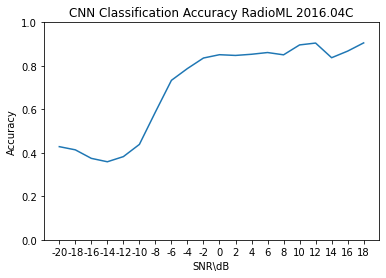

In [36]:
"""###Evaluate Test set"""
filepath = "CNN.h5"
model.save(filepath)

from keras.models import load_model
saved_model = load_model('CNN.h5')

SNR = np.unique(labels[:,1])
SNR = list(map(int, SNR))
SNR.sort()
SNR = list(map(str, SNR))

yTest_SNR_str = []
for i in yTest_SNR:
  yTest_SNR_str.append(str(i).split('\'')[1])


accuracy = []

for s in SNR:
    SNR_index = []
    SNR_Y = []
    SNR_X = []
    for index in range(0,len(yTest_SNR_str)):
        if s == yTest_SNR_str[index]:
            SNR_index.append(index)
            SNR_Y.append(yTest_ohe[index])
            SNR_X.append(xTest[index])

    y = np.array(SNR_Y)
    # print(y)
    x = np.array(SNR_X)
    result = model.evaluate(x, y, verbose=2)
    print('Accuracy for SNR = ', s, ' is ', result[1] * 100)
    accuracy.append(result[1])

  
import matplotlib.pyplot as plt
plt.ylim(0, 1)
plt.plot(SNR, accuracy)
plt.title('CNN Classification Accuracy RadioML 2016.04C')
plt.xlabel('SNR\dB')
plt.ylabel('Accuracy')
plt.show()